In [15]:
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import time
import gc
import PIL

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import (Dense, Flatten, Dropout, Reshape,BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, ReLU)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input

The Goal is to make a GAN that can generate images that look like monet paintings.

Data we are starting with is 300 Monet jpgs that are 256X256 pixels, and 7,038 256X256 other random photos

Total number of Monet images: 300


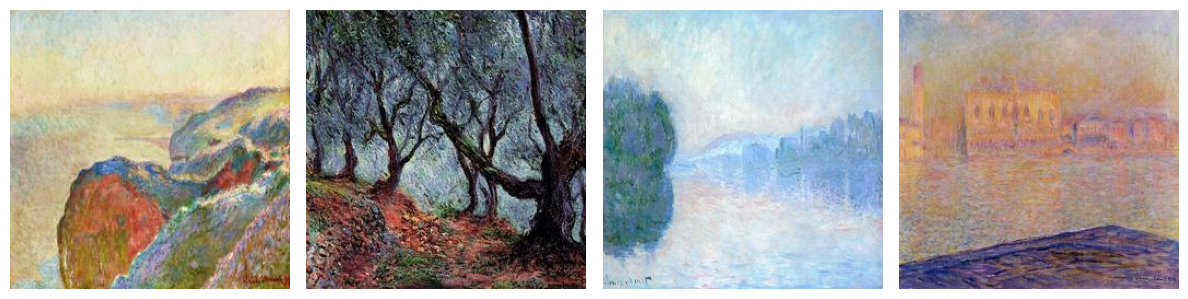

In [2]:
# Path to the Monet images
monet_paths = glob('monet_jpg/*.jpg')

# Display total number of images
print(f'Total number of Monet images: {len(monet_paths)}')

# Display a few sample images
plt.figure(figsize=(12, 6))
for i, img_path in enumerate(monet_paths[:4]):
    img = load_img(img_path)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

Total number of random images: 7038


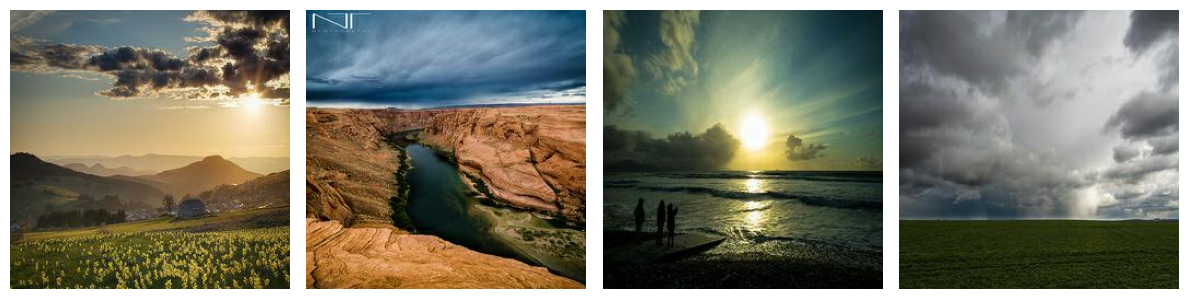

In [3]:
# Path to the Monet images
photo_paths = glob('photo_jpg/*.jpg')

# Display total number of images
print(f'Total number of random images: {len(photo_paths)}')

# Display a few sample images
plt.figure(figsize=(12, 6))
for i, img_path in enumerate(photo_paths[:4]):
    img = load_img(img_path)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
#downsize the images to 128X128 so that it takes less compute to work with and so that the 
#final folder of 7,000 plus images takes up less space

def load_and_preprocess_image(path):
    img = load_img(path, target_size=(128, 128))  # Changed from 256x256
    img_array = img_to_array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    return img_array

images = np.array([load_and_preprocess_image(img) for img in monet_paths])
print(f'Images shape: {images.shape}')




Images shape: (300, 128, 128, 3)


The shape is 300 images, 128 by 128 pixels and then 3 channels for RGB

In [12]:

dimVal = 100

#create the generator model
generator = Sequential([
    # Foundation for 8x8 feature maps
    Dense(8 * 8 * 512, use_bias=False, input_shape=(dimVal,)),
    BatchNormalization(),
    ReLU(),
    Reshape((8, 8, 512)),
    
    # Upsampling layers to reach 128x128
    Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    ReLU(),
    
    Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    ReLU(),
    
    Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    ReLU(),
    
    Conv2DTranspose(32, kernel_size=5, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    ReLU(),
    
    # Output layer
    Conv2DTranspose(3, kernel_size=5, strides=1, padding='same', use_bias=False, activation='tanh')
])

generator.summary()

C:\Users\Cale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32768)          │     3,276,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 128, 32)   │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 128, 128, 3)    │         2,400 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,764,192 (29.62 MB)

 Trainable params: 7,697,696 (29.36 MB)

 Non-trainable params: 66,496 (259.75 KB)

In [16]:
#make the discriminator model
inputShape = (128,128,3)

discriminator = Sequential([
    Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=inputShape),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),
    
    Conv2D(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),
    
    Conv2D(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),
    
    Conv2D(512, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),
    
    Flatten(),
    Dense(1, activation='sigmoid'),
])

discriminator.summary()


C:\Users\Cale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Cale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,792,897 (10.65 MB)

 Trainable params: 2,791,105 (10.65 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [17]:
#compile the models
discriminator.compile(loss='binary_crossentropy', 
                      optimizer='Adam', 
                      metrics=['accuracy'])

#so that we arent trying to train two models at once we need to stop this one while we train the generator
#then we will freeze the generator and enable this one
discriminator.trainable = False


gan_input = Input(shape=(dimVal,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='Adam')

In [18]:
#create a function to train the GAN
def train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim):
    batch_count = images.shape[0] // batch_size
    d_losses = []
    g_losses = []
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        d_loss_epoch = []
        g_loss_epoch = []
        
        for _ in range(batch_count):
            # Train Discriminator
            idx = np.random.randint(0, images.shape[0], batch_size)
            real_images = images[idx]
            
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_images = generator.predict(noise)
            
            # Labels
            real_labels = np.ones((batch_size, 1)) * 0.9  # Label smoothing
            fake_labels = np.zeros((batch_size, 1))
            
            # Train the discriminator
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_loss_epoch.append(d_loss[0])
            
            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            valid_y = np.ones((batch_size, 1))
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, valid_y)
            g_loss_epoch.append(g_loss)
            
            # Clear variables to free memory
            del real_images, fake_images, noise, real_labels, fake_labels, valid_y
            gc.collect()
        
        end_time = time.time()
        
        # Compute average losses for the epoch
        avg_d_loss = np.mean(d_loss_epoch)
        avg_g_loss = np.mean(g_loss_epoch)
        
        print(f'Epoch {epoch}/{epochs} [D loss: {avg_d_loss:.4f}] [G loss: {avg_g_loss:.4f}] Time: {end_time - start_time:.2f}s')
        
        # Save the average losses
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        
        # Collect garbage at the end of each epoch
        gc.collect()
    
    return d_losses, g_losses

In [19]:
epochs = 10
batch_size = 4
d_losses, g_losses = train_gan(generator, discriminator, gan, epochs, batch_size, dimVal)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

In [20]:
# Directory to save generated images
output_dir = 'images'

# Set the number of images to generate (between 7,000-10,000)
total_images = 7000
batch_size = 50  # Adjust based on memory constraints
images_generated = 0

while images_generated < total_images:
    current_batch_size = min(batch_size, total_images - images_generated)
    noise = np.random.normal(0, 1, (current_batch_size, dimVal))
    gen_imgs = generator.predict(noise)
    
    # Rescale images from [-1, 1] to [0, 255]
    gen_imgs = (0.5 * gen_imgs + 0.5) * 255
    gen_imgs = gen_imgs.astype(np.uint8)
    
    for i in range(current_batch_size):
        img = PIL.Image.fromarray(gen_imgs[i])
        img.save(f"{output_dir}/image_{images_generated + i + 1}.png")
    
    images_generated += current_batch_size
    print(f"Generated {images_generated}/{total_images} images.")

# Zip all the images into a zip file
zip_filename = "images.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as img_zip:
    for filename in os.listdir(output_dir):
        img_zip.write(os.path.join(output_dir, filename), arcname=filename)

print(f"All images have been generated and zipped into {zip_filename}.")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Generated 50/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Generated 100/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Generated 150/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Generated 200/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Generated 250/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Generated 300/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Generated 350/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Generated 400/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Generated 450/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Generated 500/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Generated 550/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Generated 600/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Generated 650/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Generated 700/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Generated 750/7000 images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
#I got a ton of help and borrowed code from 
#https://www.kaggle.com/code/grainier/generating-artwork-with-gans/notebook
#becuase the class did not go over how to actually implement GANs in any way